# Variational AutoEncoder

## Biweekly Report 3

## Jake Watts

In this section of the report, I use a Variational AutoEncoder (VAE) trained on MNIST data to generate images of hand-written digits. My goal is to explore the VAE architecture and output in order to better understand it.

Sources:

https://keras.io/examples/generative/vae/

https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE

https://www.tensorflow.org/tutorials/generative/cvae#load_the_mnist_dataset

https://arxiv.org/abs/1312.6114

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

## MNIST Data

MNIST is a dataset containing 70,000 labeled, hand-written digits. The images are black and white and have 28x28 pixels. Since the data is not being used for classification we can concatenate the training and testing sets.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

Below is a visualization of the first 25 digits in the data.

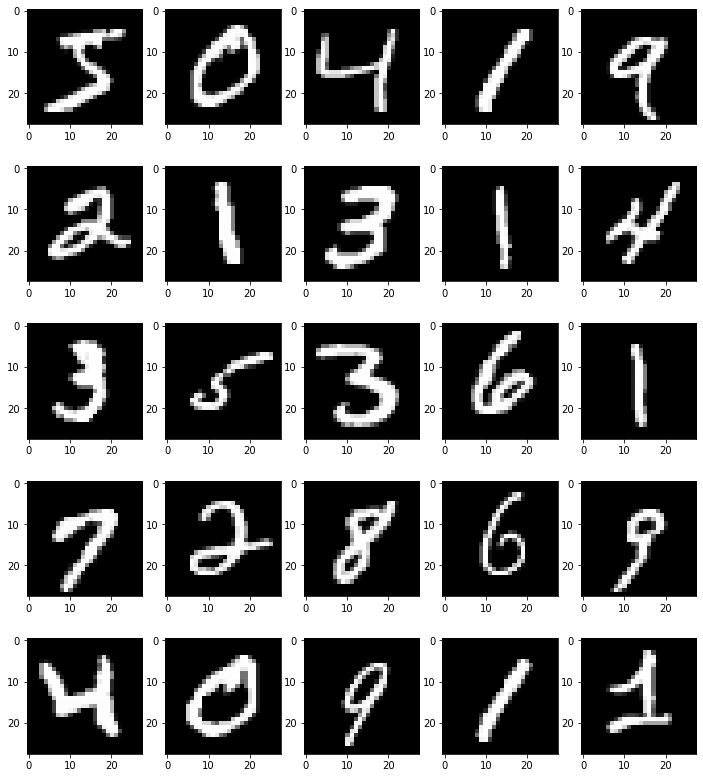

In [ ]:
figure = plt.figure(figsize=(12, 14))

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(x_train[i], cmap="Greys_r")
plt.show()

## VAE Architecture

A VAE is similar to an autoencoder in that it compresses high-dimensional data into a smaller representation. However, it is different in that instead of mapping data unto a single latent vector it maps the data unto a probability distribution. Training a VAE creates a continuous latent space that can be used for image generation.

`Sampling()` creates a sampling layer to be used in the model's encoder. It takes `z_mean` ($\mu$) and `z_log_var` ($\log{\sigma^2}$) as inputs and returns `z`.

`z` is defined by the formula $z = \mu + \sigma\odot\epsilon$. Where $\epsilon$ has a standard normal distribution. Multiplying the parameters from the model by $\epsilon$ essentially allows us to randomly sample a latent vector.

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Below we can see the architecture for the `encoder`. The `encoder` takes images from the MNIST dataset as input. It has a convolutional layer with 32 filters followed by a layer with 64 filters. Following the convolutional layers, it flattens the output and then feeds it into a dense layer. The dense layer is fed into two different dense layers, one representing the $\mu$ and the other representing $\log{\sigma^2}$ of z, both of size 2. Those outputs are then used by `Sampling()` to create the latent vector `z`.

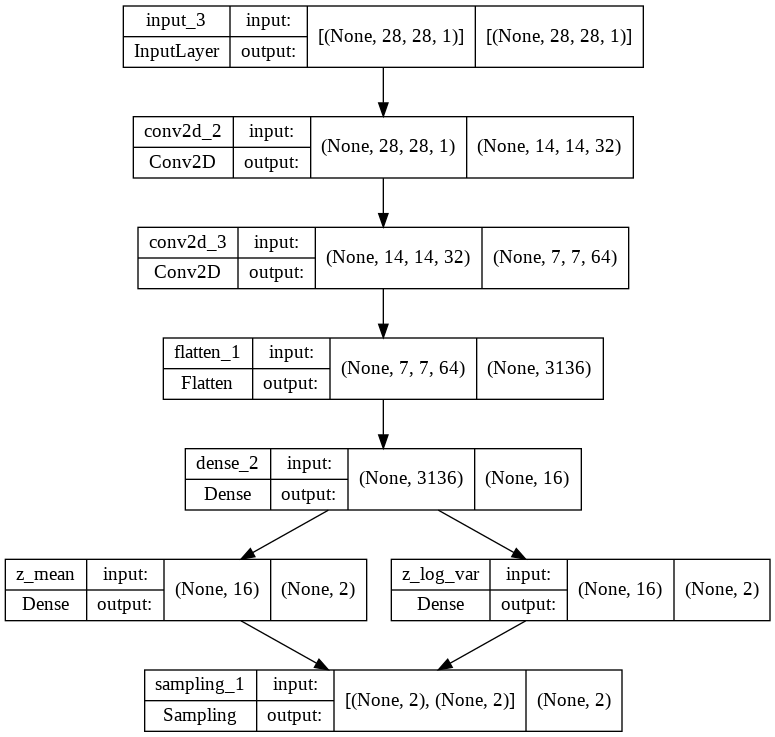

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

plot_model(encoder, to_file='model.png', show_shapes=True, show_layer_names=True)

The `decoder` is essentially the opposite of the `encoder` in that it takes `z` as an input and returns a 28x28 image. The purpose of the decoder is to generate an image based off the vector sampled by the `encoder`.

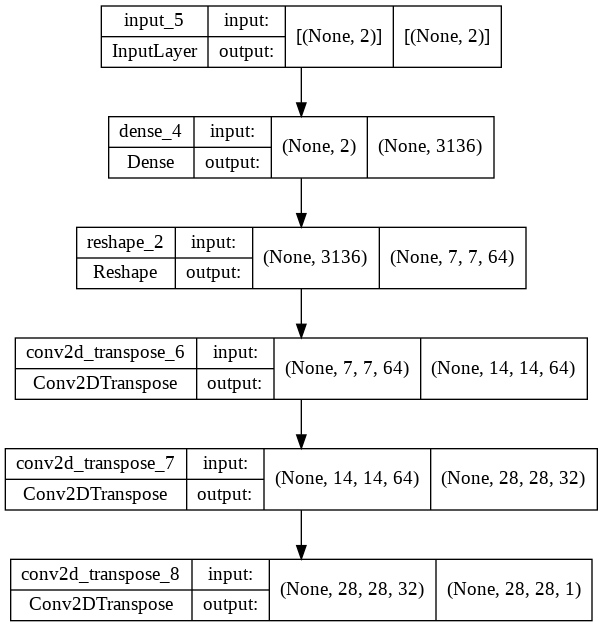

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

plot_model(decoder, to_file='model.png', show_shapes=True, show_layer_names=True)

## Training

To train the model we also need to define the loss function. The loss is calculated by subtracting the Kullback–Leibler divergence from the reconstruction loss.

The Kullback–Leibler divergence is a measure of similarity between distributions. It is included in the loss function to measure how similar the distribution is a standard normal distribution.


The reconstruction loss is a measure of the similarity between the image output and the expected output.

In [ ]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Now we train the VAE with an Adam optimizer for 30 epochs.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
h_callback = vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 5s 7ms/step - loss: 256.1624 - reconstruction_loss: 210.7401 - kl_loss: 1.9524
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 191.1082 - reconstruction_loss: 186.8474 - kl_loss: 2.3368
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 184.4194 - reconstruction_loss: 180.5907 - kl_loss: 2.2242
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - loss: 171.4154 - reconstruction_loss: 163.4120 - kl_loss: 3.3798
Epoch 5/30
547/547 [==============================] - 4s 7ms/step - loss: 158.9940 - reconstruction_loss: 154.2817 - kl_loss: 3.7641
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - loss: 155.4557 - reconstruction_loss: 151.5928 - kl_loss: 3.7972
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - loss: 154.1211 - reconstruction_loss: 149.8910 - kl_loss: 3.8255
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - l

Looking at the loss we can see that the reconstruction loss decreases rapidly during the first 5 epochs and then decreases more slowly in the remaining epochs. The KL loss does not change much and actually increases as training goes on, indicating that the distributions are deviating from a standard normal. This is interesting to see as I have never trained a model that is trying to optimize two things at once and it appears that in this case, the improvements in reconstruction take priority in decreasing total loss.

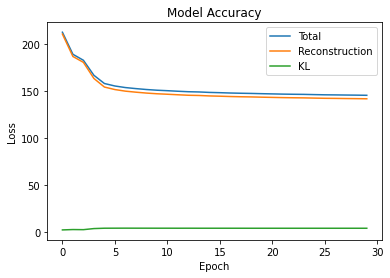

In [ ]:
plt.figure()
plt.plot(h_callback.history['loss'])
plt.plot(h_callback.history['reconstruction_loss'])
plt.plot(h_callback.history['kl_loss'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Total', 'Reconstruction', 'KL'], loc='upper right')
plt.show()

## Evaluation

Now we can visualize the created latent space. Here we take pairs of values ranging from -1 to 1 and visualize the images using the decoder. For the most part, the values can be distinguished from each other. Since the latent space is continuous we can also see areas where numbers look like a middle ground between two numbers. For example, if we look from left to right on the top row we can see what looks like an 8 slowly change to a 5 then to a 6 then to a zero.

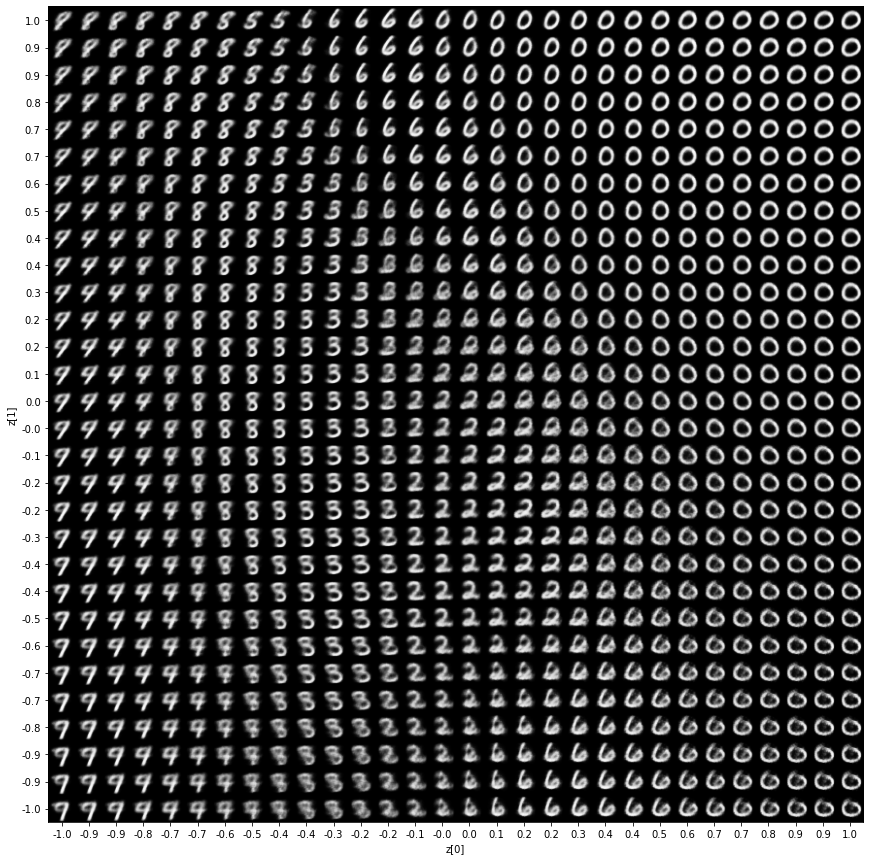

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

We can also visualize the distributions of each number by using the encoder to map the latent vectors from training images. Numbers like 1, 0, and 6 appear to be distinctly separated while some numbers like 9, 4, 3, and 2 appear to be more mixed together.

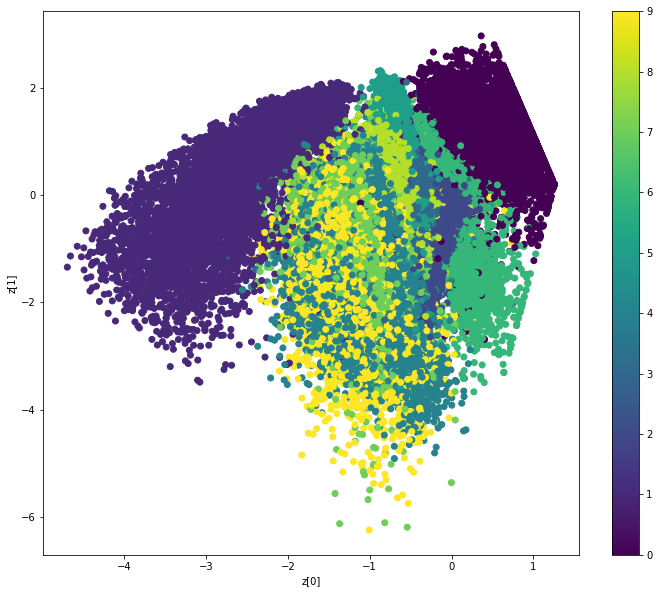

In [ ]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

`display imgs` allows us to view mulitple images in a line.

In [ ]:
def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

We can also look compare the input to the output of the VAE. Below are the first ten images.

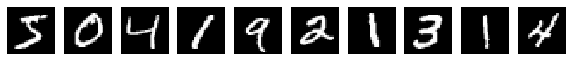

In [ ]:
imgs = x_train[0:10]
display_imgs(imgs)

Putting the 10 images into the encoder gives us sample latent vectors. Running those through the decoder we get the following images. Some are fairly similar to the inputs and some are fairly different. This is due to the stochastic nature of the model. 

It is also worth noting that 1 and 0 both have a distribution that does not overlap much with other distributions and they both show clearly. While other numbers with overlapping distributions appear to be more blurry.

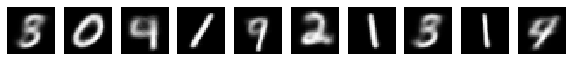

In [ ]:
mu, sigma, ran = vae.encoder.predict(imgs)
gi = vae.decoder.predict(ran)
display_imgs(gi)

## Summary

Overall this was a helpful first step in understanding VAEs. I found it cool that the model's distribution for different numbers was fairly well separated for some numbers despite the fact that the model was never given training labels. In the next section of this report, I will experiment with changes in the VAE architecture.